In [238]:
######################### Libs #########################
from tkinter.font import names
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_sequence
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import argparse
# import summary
from model_model import AEPPV1, AEPPV2, AEPPV4, AEPPV9
from model_dataset import DS_Tools
# this is used for CTC pred
from model_dataset import WordDatasetPhoneseq as TrainDataset
from model_dataset import TargetVowelDatasetPhoneseq as TestDataset
from model_dataset import Normalizer, DeNormalizer, TokenMap, WordDictionary
from model_dataset import MelSpecTransformDB as TheTransform
from paths import *
from misc_my_utils import *
from misc_recorder import *
from model_loss import *
from model_padding import generate_mask_from_lengths_mat

In [233]:
REC_SAMPLE_RATE = 16000
N_FFT = 400
N_MELS = 64
BATCH_SIZE = 1
LOADER_WORKER = 32

In [234]:
target_path = src_

In [235]:
t_set = pd.read_csv(os.path.join(target_path, f"phi-T-guide.csv"))
st_set = pd.read_csv(os.path.join(target_path, f"phi-ST-guide.csv"))
integrated = pd.concat([t_set, st_set], ignore_index=True, sort=False)

In [236]:
def norm_mvn_manual(mel_spec, mean, std):
    eps = 1e-9
    norm_spec = (mel_spec - mean) / (std + eps)
    return norm_spec

def mv_get(mel_spec):
    mel_spec = mel_spec.squeeze(0)
    mean = mel_spec.mean()
    std = mel_spec.std(unbiased=False)
    return mean, std

def norm_mvn(mel_spec):
    eps = 1e-9
    mean = mel_spec.mean()
    std = mel_spec.std(unbiased=False)
    norm_spec = (mel_spec - mean) / (std + eps)
    return norm_spec

In [240]:
class MelSpecTransformNoNorm(nn.Module): 
    def __init__(self, sample_rate, n_fft=400, n_mels=64): 
        super().__init__()
        self.sample_rate = sample_rate
        n_stft = int((n_fft//2) + 1)
        self.transform = torchaudio.transforms.MelSpectrogram(sample_rate, n_mels=n_mels, n_fft=n_fft)
        self.inverse_mel = torchaudio.transforms.InverseMelScale(sample_rate=sample_rate, n_mels=n_mels, n_stft=n_stft)
        self.grifflim = torchaudio.transforms.GriffinLim(n_fft=n_fft)
        self.amplitude_to_DB = torchaudio.transforms.AmplitudeToDB(stype='power')

    def forward(self, waveform): 
        # transform to mel_spectrogram
        mel_spec = self.transform(waveform)  # (channel, n_mels, time)
        # mel_spec = F.amplitude_to_DB(mel_spec)
        mel_spec = self.amplitude_to_DB(mel_spec)
        # mel_spec = torch.tensor(librosa.power_to_db(mel_spec.squeeze().numpy()))
        mel_spec = mel_spec.squeeze()
        mel_spec = mel_spec.permute(1, 0) # (F, L) -> (L, F)
        return mel_spec

In [241]:
mytrans_nonorm = MelSpecTransformNoNorm(sample_rate=REC_SAMPLE_RATE, 
                    n_fft=N_FFT, n_mels=N_MELS)

In [242]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title, fontsize=24)
    ax.set_ylabel(ylabel, fontdict={"fontsize": 18})
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontsize(18) for label in labels]
    # ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest")

def plot_spectrogram_lined(specgram, title=None, ylabel="freq_bin", ax=None, flines=None, dlines=None, dlines2=None, burstlines=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title, fontsize=24)
    ax.set_ylabel(ylabel, fontdict={"fontsize": 18})
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontsize(18) for label in labels]
    
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest")
    
    # Draw vertical lines at specified x-values
    if flines is not None:
        for x in flines:
            ax.axvline(x=x, color='red', linestyle='-', linewidth=2)
    if dlines is not None:
        for x in dlines:
            ax.axvline(x=x, color='blue', linestyle='--', linewidth=1)
    if dlines2 is not None:
        for x in dlines2:
            ax.axvline(x=x, color='orange', linestyle='--', linewidth=1)
    if burstlines is not None:
        for x in burstlines:
            ax.axvline(x=x, color='purple', linestyle='dashdot', linewidth=1)

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, flines=None, dlines=None, dlines2=None, burstlines=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    # Draw vertical lines at specified x-values
    ax = axes[0]
    if flines is not None:
        for x in flines:
            ax.axvline(x=x, color='red', linestyle='-', linewidth=2)
    if dlines is not None:
        for x in dlines:
            ax.axvline(x=x, color='blue', linestyle='--', linewidth=1)
    if dlines2 is not None:
        for x in dlines2:
            ax.axvline(x=x, color='orange', linestyle='--', linewidth=1)
    if burstlines is not None:
        for x in burstlines:
            ax.axvline(x=x, color='purple', linestyle='dashdot', linewidth=1)
    

def frame_to_time(frame_index, sr=16000, hop_length=200):
    return frame_index * hop_length / sr

In [243]:
phone_rec_dir = train_cut_phone_
check_dir = os.path.join(model_save_, "C_0Tg-0915163757-5", "guides")

In [244]:
st_guide = pd.read_csv(os.path.join(check_dir, "ST-valid.csv"))

In [245]:
picked_idx = random.randint(0, len(st_guide)-1)

In [246]:
noise_gen = HarmonicNoiseGen(sample_rate=16000, 
                                amplitude_scale=0.004, 
                                oscillation_scale=0.0006, f_0=50)
silence_duration = SilenceSampler_for_TV(fixlength=False).sample(len(st_guide))
noise_set = noise_gen.generate_samples(np.array(silence_duration))

HarmonicNoiseGen: sample_rate=16000, amplitude_scale=0.004, oscillation_scale=0.0006, f_0=50


In [247]:
def get_audio_st(pre_, stop_, vowel_, src_dir=phone_rec_dir): 
    S_name = os.path.join(
        src_dir, 
        pre_
    )
    T_name = os.path.join(
        src_dir, 
        stop_
    )
    V_name = os.path.join(
        src_dir, 
        vowel_
    )

    S_data, sample_rate_S = torchaudio.load(S_name, normalize=True)
    T_data, sample_rate_T = torchaudio.load(T_name, normalize=True)
    V_data, sample_rate_V = torchaudio.load(V_name, normalize=True)
    assert sample_rate_S == sample_rate_T == sample_rate_V

    data = torch.cat([S_data, T_data, V_data], dim=1)
    return data

def get_audio_tt(pre_sound, stop_, vowel_, src_dir=phone_rec_dir): 
    T_name = os.path.join(
        src_dir, 
        stop_
    )
    V_name = os.path.join(
        src_dir, 
        vowel_
    )

    # S_data, sample_rate_S = torchaudio.load(S_name, normalize=True)
    S_data = pre_sound
    T_data, sample_rate_T = torchaudio.load(T_name, normalize=True)
    V_data, sample_rate_V = torchaudio.load(V_name, normalize=True)
    assert sample_rate_T == sample_rate_V

    data = torch.cat([S_data, T_data, V_data], dim=1)
    return data

In [141]:
picked_idx = random.randint(0, len(st_guide)-1)

st_audio = get_audio_st(st_guide.iloc[picked_idx]["pre_path"], st_guide.iloc[picked_idx]["stop_path"], st_guide.iloc[picked_idx]["vowel_path"])
tt_audio = get_audio_tt(noise_set[picked_idx], st_guide.iloc[picked_idx]["stop_path"], st_guide.iloc[picked_idx]["vowel_path"])

st_spec_nonorm = mytrans_nonorm(st_audio)
tt_spec_nonorm = mytrans_nonorm(tt_audio)

mean, std = mv_get(st_spec_nonorm)
st_spec_newnorm = norm_mvn_manual(st_spec_nonorm, mean, std)
tt_spec_newnorm = norm_mvn_manual(tt_spec_nonorm, mean, std)

st_spec = norm_mvn(st_spec_nonorm)
tt_spec = norm_mvn(tt_spec_nonorm)


# plot_spectrogram(st_spec.T, title=f"Spectrogram")
# plot_spectrogram(tt_spec.T, title=f"Spectrogram")

# plot_spectrogram(st_spec_nonorm.T, title=f"Spectrogram")
# plot_spectrogram(tt_spec_nonorm.T, title=f"Spectrogram")

In [248]:
from scipy.spatial.distance import euclidean, cosine

In [261]:
mv_config = pickle.load(open(os.path.join(src_, "mv_config.pkl"), "rb"))

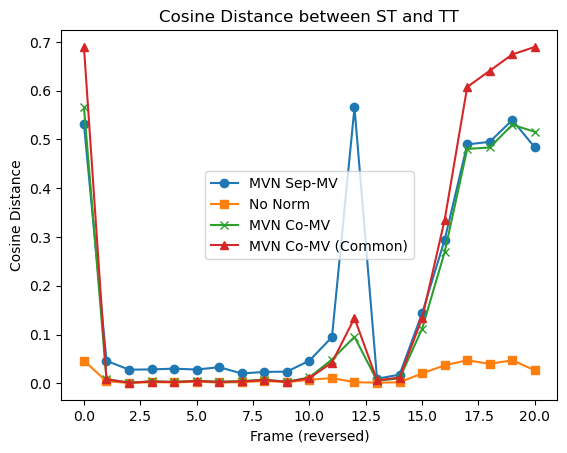

In [277]:
picked_idx = random.randint(0, len(st_guide)-1)

st_audio = get_audio_st(st_guide.iloc[picked_idx]["pre_path"], st_guide.iloc[picked_idx]["stop_path"], st_guide.iloc[picked_idx]["vowel_path"])
tt_audio = get_audio_tt(noise_set[picked_idx], st_guide.iloc[picked_idx]["stop_path"], st_guide.iloc[picked_idx]["vowel_path"])


st_spec_nonorm = mytrans_nonorm(st_audio)
tt_spec_nonorm = mytrans_nonorm(tt_audio)

mean, std = mv_get(st_spec_nonorm)
st_spec_newnorm = norm_mvn_manual(st_spec_nonorm, mean, std)
tt_spec_newnorm = norm_mvn_manual(tt_spec_nonorm, mean, std)

st_spec = norm_mvn(st_spec_nonorm)
tt_spec = norm_mvn(tt_spec_nonorm)

st_spec_commonnorm = norm_mvn_manual(st_spec_nonorm, mv_config["mean"], mv_config["std"])
tt_spec_commonnorm = norm_mvn_manual(tt_spec_nonorm, mv_config["mean"], mv_config["std"])


dist_list = []
dist_list_nonorm = []
dist_list_newnorm = []
dist_list_commonnorm = []
for i in range(min(len(st_spec), len(tt_spec))):
    dist_list.append(cosine(st_spec[-i], tt_spec[-i]))
    dist_list_nonorm.append(cosine(st_spec_nonorm[-i], tt_spec_nonorm[-i]))
    dist_list_newnorm.append(cosine(st_spec_newnorm[-i], tt_spec_newnorm[-i]))
    dist_list_commonnorm.append(cosine(st_spec_commonnorm[-i], tt_spec_commonnorm[-i]))

import matplotlib.pyplot as plt

# Sample data for two groups
x_values = range(len(dist_list))

# Plotting the line graph
plt.plot(x_values, dist_list, label='MVN Sep-MV', marker='o')
plt.plot(x_values, dist_list_nonorm, label='No Norm', marker='s')
plt.plot(x_values, dist_list_newnorm, label='MVN Co-MV', marker='x')
plt.plot(x_values, dist_list_commonnorm, label='MVN Co-MV (Common)', marker='^')

# Adding title and labels
plt.title('Cosine Distance between ST and TT')
plt.xlabel('Frame (reversed)')
plt.ylabel('Cosine Distance')

# Adding legend to distinguish between the two groups
plt.legend()

# Display the graph
plt.show()


In [ ]:
class TargetVowelDatasetManualNorm(Dataset): 
    # Target means the phenomenon-target, that is, e.g. /th/ or /st/. 
    # This dataset additionally returns the phone seq. 
    # NOTE: for TV condition we add silence as # in the place of S
    # This dataset will take in mean and variance from the outside and 
    # conduct normalization with the data. 
    def __init__(self, src_dir, guide_,  
                 mapper=None, transform=None, normalizer=None, plosive_suffix="", 
                 noise_fixlength=False, noise_amplitude_scale=0.01, mv_config=None): 
        """
            Parameters:
            src_dir (str): Source directory to read sound. 
            guide_ (str or pd.DataFrame): Guide file path or DataFrame containing the dataset information.
            is_train (bool): Flag indicating if the dataset is for training. Default is True.
            mapper (optional): Used to map between tag encoding and text, currently not used. Default is None.
            transform (optional): Mel-transformation. Default is None.
            normalizer (optional): Normalization. Default is None.
            plosive_suffix (str): Suffix to distinguish between different types of plosives. Default is "".
            noise_fixlength (bool): Flag to determine if noise should have a fixed length. Default is False.
            noise_amplitude_scale (float): Amplitude scale for noise generation. Default is 0.01.
            mv_config (dict, optional): Dictionary containing mean and variance configuration. Default is None.
            hop_length (int): Hop length for calculating between frame and time. Default is 400.
        """
        # Read the guide file
        if isinstance(guide_, str):
            guide_file = pd.read_csv(guide_)
        elif isinstance(guide_, pd.DataFrame):
            guide_file = guide_
        else:
            raise Exception("Guide neither to read or to be used directly")
        
        # ""即不區分ST和T，"H"則是區分 -> ?
        self.plosive_suffix = plosive_suffix

        # Load in the data cols 
        pre_path_col = guide_file["pre_path"]
        stop_path_col = guide_file["stop_path"]
        vowel_path_col = guide_file["vowel_path"]
        phi_type_col = guide_file["phi_type"]
        stop_name_col = guide_file["stop"]
        vowel_name_col = guide_file["vowel"]

        self.silence_duration = SilenceSampler_for_TV(fixlength=noise_fixlength).sample(len(stop_name_col))
        
        self.guide_file = guide_file
        self.dataset = stop_path_col.tolist()
        self.pre_path = pre_path_col.tolist()
        self.vowel_path = vowel_path_col.tolist()
        self.phi_type = phi_type_col.tolist()
        self.stop_name = stop_name_col.tolist()
        self.vowel_name = vowel_name_col.tolist()

        self.src_dir = src_dir
        self.transform = transform
        self.normalizer = normalizer
        self.mapper = mapper
        noise_gen = HarmonicNoiseGen(sample_rate=16000, 
                                     amplitude_scale=noise_amplitude_scale, 
                                     oscillation_scale=0.0006, f_0=50)
        self.noise_set = noise_gen.generate_samples(np.array(self.silence_duration))


        if mv_config is not None: 
            self.mean = mv_config["mean"]
            self.std = mv_config["std"]
            print(f"MV: {self.mean}, {self.std}")
        else: 
            print("No mean and variance provided, calculating from the data ...")
            self.mean, self.std = self.___getmv()
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx): 
        mel_data, this_phi_type, this_stop_name, this_phone_seq = self.___loaditem(idx)

        if self.normalizer: 
            mel_data = self.normalizer(mel_data, self.mean, self.std)
        
        return mel_data, this_phi_type, this_stop_name, this_phone_seq
    
    def ___getmv(self): 
        # Load the data and calculate the mean and variance
        mel_data_list = []

        for idx in range(len(self.dataset)): 
            mel_data, _, _, _ = self.___loaditem(idx)
            mel_data_list.append(mel_data)

        mel_data = torch.cat(mel_data_list, dim=0)

        return mel_data.mean(), mel_data.std()
    
    def ___loaditem(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        if self.phi_type[idx] == "ST": 
            # read two and concat
            S_name = os.path.join(
                self.src_dir, 
                self.pre_path[idx]
            )
            T_name = os.path.join(
                self.src_dir, 
                self.dataset[idx]
            )
            V_name = os.path.join(
                self.src_dir, 
                self.vowel_path[idx]
            )

            S_data, sample_rate_S = torchaudio.load(S_name, normalize=True)
            T_data, sample_rate_T = torchaudio.load(T_name, normalize=True)
            V_data, sample_rate_V = torchaudio.load(V_name, normalize=True)
            assert sample_rate_S == sample_rate_T == sample_rate_V

            data = torch.cat([S_data, T_data, V_data], dim=1)
            phoneseq = torch.tensor([self.mapper.encode(segment) for segment in ['S', self.stop_name[idx], self.vowel_name[idx]]], 
                                    dtype=torch.long)
        else: 
            # Here we don't need to repair, as any sequence could fit in as long as it starts woith #
            # "T"
            # NOTE: in this way we equate STV and #TV conditions and they are now directly comparable. 
            T_name = os.path.join(
                self.src_dir, 
                self.dataset[idx]
            )
            V_name = os.path.join(
                self.src_dir, 
                self.vowel_path[idx]
            )
            Sil_data = self.noise_set[idx]
            T_data, sample_rate_T = torchaudio.load(T_name, normalize=True)
            V_data, sample_rate_V = torchaudio.load(V_name, normalize=True)
            assert sample_rate_T == sample_rate_V

            data = torch.cat([Sil_data, T_data, V_data], dim=1)
            phoneseq = torch.tensor([self.mapper.encode(segment) for segment in [self.stop_name[idx] + self.plosive_suffix, self.vowel_name[idx]]], 
                                    dtype=torch.long)   # 'SIL', 

        if self.transform:
            data = self.transform(data)
        
        return data, self.phi_type[idx], self.stop_name[idx], phoneseq

    @staticmethod
    def collate_fn(data):
        # only working for one data at the moment
        batch_first = True
        xx, phi_type, stop_name, phoneseq = zip(*data)
        x_lens = [len(x) for x in xx]
        xx_pad = pad_sequence(xx, batch_first=batch_first, padding_value=0)
        phoneseq_lens = [len(x) for x in phoneseq]
        phoneseq_pad = pad_sequence(phoneseq, batch_first=batch_first, padding_value=0)
        return (xx_pad, phoneseq_pad), (x_lens, phoneseq_lens), phi_type, stop_name

## MV calculator

In [161]:
# Here is a Python class for accumulatively calculating mean and variance using Welford's method:

class OnlineMeanVariance:
    def __init__(self):
        self.n = 0       # Number of data points
        self.mean = 0.0   # Running mean
        self.M2 = 0.0     # Sum of squared differences from the mean (for variance calculation)
    
    def update(self, x):
        """Add a new data point and update mean and variance"""
        self.n += 1
        delta = x - self.mean
        self.mean += delta / self.n
        delta2 = x - self.mean
        self.M2 += delta * delta2
    
    def get_mean(self):
        """Return the current mean"""
        return self.mean
    
    def get_variance(self):
        """Return the current variance"""
        if self.n < 2:
            return float('nan')  # Variance is undefined for fewer than 2 data points
        return self.M2 / (self.n - 1)  # Use (n-1) for sample variance

    def get_population_variance(self):
        """Return the population variance (divide by n instead of n-1)"""
        if self.n < 1:
            return float('nan')  # Variance is undefined for no data points
        return self.M2 / self.n  # Use n for population variance

# Example usage
online_stats = OnlineMeanVariance()
data = [5.0, 7.0, 8.0, 10.0, 9.0, 11.0]

for value in data:
    online_stats.update(value)

mean = online_stats.get_mean()
variance = online_stats.get_variance()

mean, variance


(8.333333333333334, 4.666666666666666)

In [163]:
import numpy as np
import torch

class OnlineMeanVariance:
    def __init__(self):
        self.n = 0       # Number of samples
        self.mean = 0.0  # Running mean (scalar)
        self.M2 = 0.0    # Running sum of squared differences from the mean (scalar)

    def update(self, x):
        """Add a new numpy array or torch tensor, treating it as a single scalar sample."""
        # Compute the scalar mean of the array/tensor
        if isinstance(x, np.ndarray):
            sample_mean = x.mean()  # Numpy mean
        elif isinstance(x, torch.Tensor):
            sample_mean = x.mean()  # PyTorch mean
        else:
            raise ValueError("Input should be a numpy array or a torch tensor.")

        # Update running mean and M2
        self.n += 1
        delta = sample_mean - self.mean
        self.mean += delta / self.n
        delta2 = sample_mean - self.mean
        self.M2 += delta * delta2

    def get_mean(self):
        """Return the current mean."""
        return self.mean

    def get_variance(self):
        """Return the current sample variance."""
        if self.n < 2:
            return float('nan')  # Variance is undefined for fewer than 2 samples
        return self.M2 / (self.n - 1)  # Sample variance (unbiased)

    def get_population_variance(self):
        """Return the population variance (divide by n instead of n-1)."""
        if self.n < 1:
            return float('nan')  # Variance is undefined for no samples
        return self.M2 / self.n  # Population variance (biased)

    def get_std(self, unbiased=True):
        """Return the standard deviation based on the variance."""
        variance = self.get_variance() if unbiased else self.get_population_variance()
        if variance is None:
            return None
        return np.sqrt(variance) if isinstance(variance, (float, np.ndarray)) else torch.sqrt(variance)

# Example usage with numpy
online_stats_np = OnlineMeanVariance()
data_np = [np.array([1.0, 2.0, 3.0]), np.array([4.0, 5.0, 6.0]), np.array([7.0, 8.0, 9.0])]

for value in data_np:
    online_stats_np.update(value)

mean_np = online_stats_np.get_mean()
std_np = online_stats_np.get_std()

# Example usage with PyTorch tensors
online_stats_torch = OnlineMeanVariance()
data_torch = [torch.tensor([1.0, 2.0, 3.0]), torch.tensor([4.0, 5.0, 6.0]), torch.tensor([7.0, 8.0, 9.0])]

for value in data_torch:
    online_stats_torch.update(value)

mean_torch = online_stats_torch.get_mean()
std_torch = online_stats_torch.get_std()

mean_np, std_np, mean_torch, std_torch


(5.0, 3.0, tensor(5.), tensor(3.))

In [164]:
import numpy as np
import torch

class OnlineMeanVariance:
    def __init__(self):
        self.n = 0       # Number of samples
        self.mean = 0.0  # Running mean (scalar)
        self.M2 = 0.0    # Running sum of squared differences from the mean (scalar)

    def update(self, x):
        """Add a new sample (numpy array or torch tensor)."""
        # Compute the scalar mean of the array/tensor using a common method
        sample_mean = x.mean().item()  # .item() ensures it's a scalar float value

        # Update running mean and M2
        self.n += 1
        delta = sample_mean - self.mean
        self.mean += delta / self.n
        delta2 = sample_mean - self.mean
        self.M2 += delta * delta2

    def get_mean(self):
        """Return the current mean."""
        return self.mean

    def get_variance(self):
        """Return the current sample variance."""
        if self.n < 2:
            return float('nan')  # Variance is undefined for fewer than 2 samples
        return self.M2 / (self.n - 1)  # Sample variance (unbiased)

    def get_population_variance(self):
        """Return the population variance (divide by n instead of n-1)."""
        if self.n < 1:
            return float('nan')  # Variance is undefined for no samples
        return self.M2 / self.n  # Population variance (biased)

    def get_std(self, unbiased=True):
        """Return the standard deviation based on the variance."""
        if unbiased:
            variance = self.get_variance()
        else:
            variance = self.get_population_variance()

        if variance is float('nan'):
            return float('nan')
        
        return np.sqrt(variance)  # Common method for both arrays/tensors



(5.0, 3.0, 5.0, 3.0)

In [191]:
import numpy as np
import torch

class OnlineMeanVariance:
    def __init__(self):
        self.n = 0       # Number of samples
        self.mean = None  # Running mean (initially None)
        self.M2 = None    # Running sum of squared differences from the mean (for variance calculation)

    def update(self, x):
        """Add a new numpy array or torch tensor and update the mean and variance."""
        # Ensure the input is a numpy array or torch tensor
        if isinstance(x, np.ndarray) or isinstance(x, torch.Tensor):
            if self.mean is None:  # Initialize mean and M2 to zeros of the same shape as x
                self.mean = torch.zeros_like(x) if isinstance(x, torch.Tensor) else np.zeros_like(x)
                self.M2 = torch.zeros_like(x) if isinstance(x, torch.Tensor) else np.zeros_like(x)

            self.n += 1
            delta = x - self.mean
            self.mean += delta / self.n
            delta2 = x - self.mean
            self.M2 += delta * delta2
        else:
            raise ValueError("Input should be a numpy array or a torch tensor.")

    def get_mean(self):
        """Return the current mean as a numpy array or torch tensor."""
        return self.mean

    def get_variance(self):
        """Return the current sample variance as a numpy array or torch tensor."""
        if self.n < 2:
            return None  # Variance is undefined for fewer than 2 samples
        return self.M2 / (self.n - 1)  # Sample variance (unbiased)

    def get_population_variance(self):
        """Return the population variance (divide by n instead of n-1)."""
        if self.n < 1:
            return None  # Variance is undefined for no samples
        return self.M2 / self.n  # Population variance (biased)

    def get_std(self, unbiased=True):
        """Return the standard deviation based on the variance."""
        variance = self.get_variance() if unbiased else self.get_population_variance()
        if variance is None:
            return None
        return torch.sqrt(variance) if isinstance(variance, torch.Tensor) else np.sqrt(variance)

# Example usage with numpy
online_stats_np = OnlineMeanVariance()
data_np = [np.array([1.0, 2.0, 3.0]), np.array([4.0, 5.0, 6.0]), np.array([7.0, 8.0, 9.0])]

for value in data_np:
    online_stats_np.update(value)

mean_np = online_stats_np.get_mean()
std_np = online_stats_np.get_std()

# Example usage with PyTorch tensors
online_stats_torch = OnlineMeanVariance()
data_torch = [torch.tensor([1.0, 2.0, 3.0]), torch.tensor([4.0, 5.0, 6.0]), torch.tensor([7.0, 8.0, 9.0])]

for value in data_torch:
    online_stats_torch.update(value)

mean_torch = online_stats_torch.get_mean()
std_torch = online_stats_torch.get_std()

mean_np, std_np, mean_torch, std_torch


(array([4., 5., 6.]),
 array([3., 3., 3.]),
 tensor([4., 5., 6.]),
 tensor([3., 3., 3.]))

In [170]:
# Fixing the issue by using the correct method for unbiased standard deviation in numpy

def full_mean_std(data):
    """Compute the mean and standard deviation of the dataset at once (batch processing)."""
    if isinstance(data[0], np.ndarray):
        data_stack = np.stack(data)
    elif isinstance(data[0], torch.Tensor):
        data_stack = torch.stack(data)
    else:
        raise ValueError("Data must be a list of numpy arrays or torch tensors.")

    mean = data_stack.mean().item()  # Mean over all samples
    # In numpy, std() is unbiased by default (it divides by n-1). So no need for the unbiased argument.
    if isinstance(data_stack, np.ndarray):
        std = data_stack.std(ddof=1).item()  # ddof=1 for unbiased std
    else:
        std = data_stack.std(unbiased=True).item()  # Use unbiased=True in PyTorch
    
    return mean, std

# Re-run the tests

# Example usage with numpy arrays
online_stats_np = OnlineMeanVariance()
data_np = [np.array([1.0, 2.0, 3.0]), np.array([4.0, 5.0, 6.0]), np.array([7.0, 8.0, 9.0])]

for value in data_np:
    online_stats_np.update(value)

mean_np_online = online_stats_np.get_mean()
std_np_online = online_stats_np.get_std()

mean_np_full, std_np_full = full_mean_std(data_np)

# Example usage with PyTorch tensors
online_stats_torch = OnlineMeanVariance()
data_torch = [torch.tensor([1.0, 2.0, 3.0]), torch.tensor([4.0, 5.0, 6.0]), torch.tensor([7.0, 8.0, 9.0]), torch.tensor([1.0, 12.0, 5.0]), torch.tensor([1.0, 12.0, 5.0]), torch.tensor([1.0, 12.0, 5.0])]

for value in data_torch:
    online_stats_torch.update(value)

mean_torch_online = online_stats_torch.get_mean()
std_torch_online = online_stats_torch.get_std()

mean_torch_full, std_torch_full = full_mean_std(data_torch)

(mean_np_online, std_np_online), (mean_np_full, std_np_full), (mean_torch_online, std_torch_online), (mean_torch_full, std_torch_full)


((array([4., 5., 6.]), array([3., 3., 3.])),
 (5.0, 2.7386127875258306),
 (tensor([2.5000, 8.5000, 5.5000]), tensor([2.5100, 4.2778, 1.9748])),
 (5.5, 3.838657855987549))

In [ ]:
class TargetVowelDatasetBoundaryPhoneseq(Dataset): 
    # this mixes T and ST. 
    # Target means the phenomenon-target, that is, e.g. /th/ or /st/. 
    # NOTE: for TV condition we add silence as # in the place of S
    # NOTE: this version does not generate random silence here, because for evaluation 
    # NOTE: silence can be generated outside. 
    def __init__(self, src_dir, guide_, select=[], mapper=None, transform=None, plosive_suffix="", hop_length=400, 
                 noise_amplitude_scale=0.01):
        # guide_file = pd.read_csv(guide_)
        if isinstance(guide_, str):
            guide_file = pd.read_csv(guide_)
        elif isinstance(guide_, pd.DataFrame):
            guide_file = guide_
        else:
            raise Exception("Guide neither to read or to be used directly")
        
        self.plosive_suffix = plosive_suffix
        
        guide_file["first_sep_frame"] = guide_file.apply(lambda x: time_to_frame(x['stop_startTime'] - x['pre_startTime'], hop_length=hop_length), axis=1)
        guide_file["second_sep_frame"] = guide_file.apply(lambda x: time_to_frame(x['vowel_startTime'] - x['pre_startTime'], hop_length=hop_length), axis=1)
        
        pre_path_col = guide_file["pre_path"]
        stop_path_col = guide_file["stop_path"]
        vowel_path_col = guide_file["vowel_path"]
        phi_type_col = guide_file["phi_type"]
        stop_name_col = guide_file["stop"]
        vowel_name_col = guide_file["vowel"]
        first_sep_frame_col = guide_file["first_sep_frame"]
        second_sep_frame_col = guide_file["second_sep_frame"]
        
        # generate random length silence for TV condition
        self.silence_duration = (guide_file['stop_startTime'] - guide_file['pre_startTime']).tolist()

        self.guide_file = guide_file
        self.dataset = stop_path_col.tolist()
        self.pre_path = pre_path_col.tolist()
        self.vowel_path = vowel_path_col.tolist()
        self.phi_type = phi_type_col.tolist()
        self.stop_name = stop_name_col.tolist()
        self.vowel_name = vowel_name_col.tolist()
        self.first_sep_frame = first_sep_frame_col.tolist()
        self.second_sep_frame = second_sep_frame_col.tolist()
        self.src_dir = src_dir
        self.transform = transform

        self.mapper = mapper
        # noise_gen = WhiteNoiseGen(sample_rate=16000, amplitude_scale=noise_amplitude_scale)
        noise_gen = HarmonicNoiseGen(sample_rate=16000, 
                                     amplitude_scale=noise_amplitude_scale, 
                                     oscillation_scale=0.001, f_0=60)
        self.noise_set = noise_gen.generate_samples(np.array(self.silence_duration))
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if self.phi_type[idx] == "ST": 
            # read two and concat
            S_name = os.path.join(
                self.src_dir, 
                self.pre_path[idx]
            )
            T_name = os.path.join(
                self.src_dir, 
                self.dataset[idx]
            )
            V_name = os.path.join(
                self.src_dir, 
                self.vowel_path[idx]
            )

            S_data, sample_rate_S = torchaudio.load(S_name, normalize=True)
            T_data, sample_rate_T = torchaudio.load(T_name, normalize=True)
            V_data, sample_rate_V = torchaudio.load(V_name, normalize=True)
            assert sample_rate_S == sample_rate_T == sample_rate_V

            data = torch.cat([S_data, T_data, V_data], dim=1)
            phoneseq = torch.tensor([self.mapper.encode(segment) for segment in ['S', self.stop_name[idx], self.vowel_name[idx]]], 
                                    dtype=torch.long)
        else: 
            # "T"
            # NOTE: in this way we equate STV and #TV conditions and they are now directly comparable. 
            Sil_duration = self.silence_duration[idx]
            T_name = os.path.join(
                self.src_dir, 
                self.dataset[idx]
            )
            V_name = os.path.join(
                self.src_dir, 
                self.vowel_path[idx]
            )
            Sil_data = self.noise_set[idx]
            T_data, sample_rate_T = torchaudio.load(T_name, normalize=True)
            V_data, sample_rate_V = torchaudio.load(V_name, normalize=True)
            assert sample_rate_T == sample_rate_V

            data = torch.cat([Sil_data, T_data, V_data], dim=1)
            phoneseq = torch.tensor([self.mapper.encode(segment) for segment in [self.stop_name[idx] + self.plosive_suffix, self.vowel_name[idx]]], 
                                    dtype=torch.long)   # 'SIL', 

        if self.transform:
            data = self.transform(data)
        
        return data, self.phi_type[idx], self.stop_name[idx], self.vowel_name[idx], self.first_sep_frame[idx], self.second_sep_frame[idx], phoneseq

    @staticmethod
    def collate_fn(data):
        # only working for one data at the moment
        batch_first = True
        xx, pt, sn, vn, sf1, sf2, phoneseq = zip(*data)
        x_lens = [len(x) for x in xx]
        xx_pad = pad_sequence(xx, batch_first=batch_first, padding_value=0)
        return xx_pad, x_lens, pt, sn, vn, sf1, sf2, phoneseq

In [208]:
import numpy as np
import torch

class OnlineMeanVariance:
    def __init__(self):
        self.n = 0       # Number of samples
        self.mean = 0.0  # Running mean (scalar)
        self.M2 = 0.0    # Running sum of squared differences from the mean (scalar)

    def update(self, x):
        """
        Add a new time-frequency tensor and update the running mean and variance using vectorized operations.
        x: numpy array or torch tensor with shape (time, frequency)
        """
        num_samples = x.size(0)  # Number of timeframes (rows)
        sample_means = x.mean(dim=1)
        
        # Update the number of samples (add the number of timeframes)
        total_samples = self.n + num_samples

        # Update running mean using vectorized batch update
        delta = sample_means - self.mean  # Mean difference between current batch and running mean
        self.mean += (delta / total_samples).sum()  # Update running mean

        # Update M2 (sum of squared differences) using batch variance
        delta2 = sample_means - self.mean
        self.M2 += (delta * delta2).sum()

        # Update total number of samples
        self.n = total_samples

    def get_mean(self):
        """Return the current mean."""
        return self.mean

    def get_variance(self):
        """Return the current sample variance."""
        if self.n < 2:
            return float('nan')  # Variance is undefined for fewer than 2 samples
        return self.M2 / (self.n - 1)  # Sample variance (unbiased)

    def get_population_variance(self):
        """Return the population variance (divide by n instead of n-1)."""
        if self.n < 1:
            return float('nan')  # Variance is undefined for no samples
        return self.M2 / self.n  # Population variance (biased)

    def get_std(self, unbiased=True):
        """Return the standard deviation based on the variance."""
        if unbiased:
            variance = self.get_variance()
        else:
            variance = self.get_population_variance()

        return np.sqrt(variance) if isinstance(variance, (float, np.ndarray)) else torch.sqrt(torch.tensor(variance))

In [213]:
# Full dataset mean and variance calculation (traditional method)

def full_mean_variance(data):
    """
    Compute the mean and variance of the whole dataset (batch processing).
    data: list of numpy arrays or torch tensors of shape (time, frequency).
    Treats each timeframe (row) as one sample.
    """
    # Stack the data into a single array/tensor
    if isinstance(data[0], np.ndarray):
        data_stack = np.vstack(data)  # Stack numpy arrays vertically (along time dimension)
        mean = np.mean(data_stack)  # Full mean
        variance = np.var(data_stack, ddof=1)  # Full variance (ddof=1 for unbiased sample variance)
    elif isinstance(data[0], torch.Tensor):
        data_stack = torch.vstack(data)  # Stack tensors vertically (along time dimension)
        mean = torch.mean(data_stack)  # Full mean
        variance = torch.var(data_stack, unbiased=False)  # Full variance (unbiased)
    else:
        raise ValueError("Data must be a list of numpy arrays or torch tensors.")
    
    return mean.item(), variance.item()  # Convert to scalar values

In [228]:
# Python code to generate a list of tensors with shape (1, 1) following the standard normal distribution

import torch

def generate_normal_tensors(num_tensors):
    """Generates a list of tensors with shape (1, 1) from a standard normal distribution."""
    tensor_list = [torch.randn(1, 5) for _ in range(num_tensors)]
    return tensor_list

In [229]:
online_stats_torch = OnlineMeanVariance()
data_torch = []
for i in range(1000): 
    # random_framlength = random.randint(5, 20)
    # data_torch.append(torch.rand(random_framlength, 1))
    data_torch.append(torch.tensor([[1.], [-1.], [-1.]]))

data_torch = generate_normal_tensors(1000)

for value in data_torch:
    online_stats_torch.update(value)

mean_torch = online_stats_torch.get_mean()
std_torch = online_stats_torch.get_std()

mean_torch_full, var_torch_full = full_mean_variance(data_torch)

mean_torch, std_torch, mean_torch_full, var_torch_full


/tmp/ipykernel_3955798/3758902820.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return np.sqrt(variance) if isinstance(variance, (float, np.ndarray)) else torch.sqrt(torch.tensor(variance))


(tensor(0.0039), tensor(0.4460), 0.0039415727369487286, 1.0165544748306274)

In [230]:
mel_data_list = [torch.rand(3,5), torch.rand(4,5)]

mel_data = torch.cat(mel_data_list, dim=0)

In [231]:
mel_data.shape

torch.Size([7, 5])

In [2]:
import torch

In [8]:
alist = []
a = torch.rand(3, 3)
alist.append(a)
a = torch.nn.Linear(3, 3)(a)
alist.append(a)
a = torch.nn.Linear(3, 2)(a)
alist.append(a)

In [11]:
[[]] * 3

[[], [], []]

In [12]:
import torch 
import torch.nn.functional as F 

In [93]:
# Define some mock parameters 
batch_size = 5  # B 
input_output_dim = 16  # I/O 
hidden_dim = 8  # H 
seq_length = 10  # Length 
num_blocks = 3  # Number of RNN blocks 
dummy_dim = 64  # Dimension for random data to represent attention outputs 
mask_dim = 1  # Mask dimensionality 
num_layers = 2

In [94]:
# Initialize random data for hidden representations (hid_rs) and other placeholders 
hid_rs = [torch.randn(batch_size, seq_length, hidden_dim) for _ in range(num_blocks)] 
init_in = torch.randn(batch_size, 1, input_output_dim) 
in_mask = torch.ones(batch_size, seq_length)  # Placeholder mask 
hiddens = [(torch.randn(num_layers, batch_size, hidden_dim), torch.randn(num_layers, batch_size, hidden_dim)) for _ in range(num_blocks)] 

print("hid_rs[0] shape:", hid_rs[0].shape)
print("init_in shape:", init_in.shape)
print("in_mask shape:", in_mask.shape)
print("hiddens[0][0] shape:", hiddens[0][0].shape)

hid_rs[0] shape: torch.Size([5, 10, 8])
init_in shape: torch.Size([5, 1, 16])
in_mask shape: torch.Size([5, 10])
hiddens[0][0] shape: torch.Size([2, 5, 8])


In [95]:
# Placeholder for testing toy operations 
final_output_frames = []  # To store final output 
lstm_outputs, attention_outputs, block_outputs = [[] for _ in range(num_blocks)], [[] for _ in range(num_blocks)], [[] for _ in range(num_blocks)] 
attention_weights = [[] for _ in range(num_blocks)] 

In [96]:
lin1 = torch.nn.Linear(input_output_dim, hidden_dim)

In [97]:
# Iteration over sequence length 
for t in range(seq_length):  
    # Toy operation simulating linear transformation and activation (lin_1) 
    dec_x_lin1 = lin1(init_in)  # (B, 1, I/O) -> (B, 1, H), using relu as activation 
    for i in range(num_blocks): 
        # Toy LSTM block (replacing real LSTM with a simple addition operation) 
        dec_inblock_lstm, hiddens[i] = (dec_x_lin1), hiddens[i]  # Mock update hidden state 
        lstm_outputs[i].append(hiddens[i][0])  # Collect outputs    
        # Toy residual and attention mechanisms 
        dec_inblock_passer_1 = dec_inblock_lstm + dec_x_lin1  # Residual connection simulation 
        dec_inblock_attention = torch.randn(batch_size, 1, hidden_dim)  # Simulating attention output 
        attention_weight = torch.randn(batch_size, 1, seq_length)  # Simulating attention weights 
        attention_outputs[i].append(dec_inblock_attention) 
        dec_inblock_passer_2 = dec_inblock_attention + dec_inblock_passer_1  # Residual connection simulation 
        dec_inblock_lin = torch.randn(batch_size, 1, hidden_dim)  # Simulating linear transformation 
        dec_inblock_passer_3 = dec_inblock_lin + dec_inblock_passer_2  # Residual connection simulation 
        block_outputs[i].append(dec_inblock_passer_3) 
        attention_weights[i].append(attention_weight) 
    # Final output processing for this timestep (simulating lin_2) 
    dec_x_lin2 = torch.randn(batch_size, 1, input_output_dim)  # Simulating the final output 
    final_output_frames.append(dec_x_lin2) 
    # Update the input token for the next timestep 
    init_in = dec_x_lin2 

In [98]:
print("Final Output Frames Shape:", torch.stack(final_output_frames, dim=1).squeeze(2).shape)

Final Output Frames Shape: torch.Size([5, 10, 16])


In [113]:
lstm_outputs_org = [torch.unbind(torch.stack(lstm_outputs[i], dim=2), dim=0) for i in range(num_blocks)]

In [114]:
lstm_outputs_org[0][1].shape

torch.Size([5, 10, 8])

In [123]:
[torch.stack(attention_weights[i], dim=1).squeeze(-2) for i in range(num_blocks)][0].shape

torch.Size([5, 10, 10])

In [103]:
# Checking the shapes of the collected outputs 
for i in range(num_blocks): 

    print(f"Block {i+1}:") 

    print("LSTM Outputs Shape:", torch.stack(lstm_outputs[i], dim=2).shape) 

    print("Attention Outputs Shape:", torch.stack(attention_outputs[i], dim=1).squeeze(-2).shape)

    print("Block Outputs Shape:", torch.stack(block_outputs[i], dim=1).squeeze(-2).shape) 

    print("Attention Weights Shape:", torch.stack(attention_weights[i], dim=1).squeeze(-2).shape) 

Block 1:
LSTM Outputs Shape: torch.Size([2, 5, 10, 8])
Attention Outputs Shape: torch.Size([5, 10, 8])
Block Outputs Shape: torch.Size([5, 10, 8])
Attention Weights Shape: torch.Size([5, 10, 10])
Block 2:
LSTM Outputs Shape: torch.Size([2, 5, 10, 8])
Attention Outputs Shape: torch.Size([5, 10, 8])
Block Outputs Shape: torch.Size([5, 10, 8])
Attention Weights Shape: torch.Size([5, 10, 10])
Block 3:
LSTM Outputs Shape: torch.Size([2, 5, 10, 8])
Attention Outputs Shape: torch.Size([5, 10, 8])
Block Outputs Shape: torch.Size([5, 10, 8])
Attention Weights Shape: torch.Size([5, 10, 10])


In [125]:
for i in enumerate([1, 2, 3]): 
    print(i)

(0, 1)
(1, 2)
(2, 3)


: 